# Import Libraries

In [1]:
%%capture
# Imports/pips/initializations go here
import string
import types
import numpy as np
import nltk
import re
import random
import pandas as pd
from gensim.parsing.porter import PorterStemmer
from nltk.corpus import gutenberg, stopwords
from nltk.probability import FreqDist
from nltk.corpus import words
import matplotlib.pyplot as plt
import requests

from gensim.models import Word2Vec
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

!python -m spacy download en_core_web_sm
import en_core_web_sm

nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')

# Load the Data Set

In [2]:
books=[]
urls=[]
urls.append("https://www.gutenberg.org/files/51660/51660-0.txt")
# urls.append("https://www.gutenberg.org/files/20023/20023-8.txt")
# urls.append("https://www.gutenberg.org/files/36641/36641-8.txt")
# urls.append("https://www.gutenberg.org/files/63444/63444-0.txt")
# urls.append("https://www.gutenberg.org/files/1265/1265.txt")

for url in urls:
  books.append(requests.get(url).text)

**Dataset sample**

In [3]:
books[0][:300]

"ï»¿Project Gutenberg's The Girls' Book of Famous Queens, by Lydia Hoyt Farmer\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and most\r\nother parts of the world at no cost and with almost no restrictions\r\nwhatsoever.  You may copy it, give it away or re-use it under the terms of"

> - **Seems like it's need some preprossing and cleaning**

**Simple Cleaning Function**

In [4]:
import string

def prepare_data(text):
  # to lower case
  text = text.lower()
  # Remove non-ascii characters
  text = text.encode("ascii", "ignore").decode()
  # Remove \n and \r
  text = re.sub(r'[\r*\n*]+', ' ', text)
  # Remove websites and hashtags
  text = re.sub(r'_|#|http\S+|www\S+', ' ', text)
  # Substitute numbers by keyword num
  text = re.sub(r'\d+', 'num', text)
  
  # Apply tokenization
  regex = r"\w+'?\w+\s"
  words = re.findall(regex,text)
  words = [w[:-1] for w in words]
  words = [w for w in words if len(w)>1 or w in ["a", "i"]]
  unique = np.unique(words, return_counts=True)
  [[w, c] for w, c in zip(*unique) if  len(w) == 2]
  return words

words = [prepare_data(book) for book in books]
words = [y for x in words for y in x]


words = set(words)

# **Generate Incorrect Words**

In [5]:
def apply_error(word, remove=0.3, add=0.3, swap_letter=True):
  def swap(s, i, j):
    return ''.join((s[:i], s[j], s[i+1:j], s[i], s[j+1:]))

  if swap_letter:
    i = random.randint(0,len(word)-1)
    j = random.randint(0,len(word)-1)
    word = swap(word, i, j)

  letters_to_remove = int(remove*len(word))
  letters_to_add = int(add*len(word))

  for _ in range(letters_to_remove):
    i = random.randint(1,len(word))
    word = word[:i-1] + word[i:]

  lower_upper_alphabet = string.ascii_letters
  for _ in range(letters_to_add):
    random_letter = random.choice(lower_upper_alphabet)
    i = random.randint(1,len(word))
    word = word[:i] + random_letter.lower() + word[i:]

  return word

In [6]:
apply_error("hospital", remove=0.3, add=0.2, swap_letter=False)

'hyspita'

In [7]:
apply_error("hospital", remove=0.1, add=0.1)

'hospihital'

**Due to the Ram consumtion i would chose the first 100 word only**

In [8]:
correct_words = list(set(prepare_data(books[0])))[:200]

# Build the Evaluation Dataset

In [9]:
wrong_1 =[]

for correct in correct_words:
  # wrong_1.append(apply_error(correct, remove=0.1, add=0.1,swap_letter=True)) # Baseline
  wrong_1.append(apply_error(correct, remove=0.05, add=0.05)) # Don't swap

  # wrong_1.append(apply_error(correct, remove=0.2, add=0.1, swap_letter=True)) # Remove more 20%
  # wrong_1.append(apply_error(correct, remove=0.1, add=0.2, swap_letter=True)) # Add more 20%
  
  # wrong_1.append(apply_error(correct, remove=0.3, add=0.1,swap_letter=True)) # Remove more 30%
  # wrong_1.append(apply_error(correct, remove=0.1, add=0.3,swap_letter=True)) # Add more 30%

  # wrong_1.append(apply_error(correct, remove=0.5, add=0.1,swap_letter=True)) # Remove more 20%
  # wrong_1.append(apply_error(correct, remove=0.1, add=0.5,swap_letter=True)) # Add more 20%

  # wrong_1.append(apply_error(correct, remove=0.2, add=0.2,swap_letter=True)) # Romove and Add by 20%
  # wrong_1.append(apply_error(correct, remove=0.3, add=0.3,swap_letter=True)) # Romove and Add by 30%

In [10]:
df = pd.DataFrame({"correct":correct_words,"wrong_1":wrong_1})
df

,correct,wrong_1
0,perpetrated,perpetrated
1,hazard,hazaard
2,abandon,abandaondon
3,driven,drirviven
4,allow,allllow
...,...,...
195,shamed,smahed
196,singular,singulnagular
197,cabinet,cabinaebinet
198,righteous,rightheteous


# Define the AutoCorrection function

In [11]:
import spacy
from numpy import empty

def Autocorrection(correct_words,wrong_words, corrector='textblob'):
  close_matches =[]
  correct_counter = 0

  if corrector=='autocorrect':
    from autocorrect import Speller
    spell = Speller(lang='en')

  if corrector=='pyspellchecker':
    from spellchecker import SpellChecker
    spell = SpellChecker()

  if corrector=='contextualSpellCheck':
    import contextualSpellCheck
    nlp = spacy.load('en_core_web_sm')
    contextualSpellCheck.add_to_pipe(nlp)  

  if corrector=='textblob':
    from textblob import TextBlob

  for i in range(len(correct_words)):

    correct_w = correct_words[i]
    wrong = wrong_words[i]
    if corrector=='autocorrect':
      close_match = spell(wrong)

    if corrector=='pyspellchecker':
      close_match = spell.correction(wrong)
      
    if corrector=='contextualSpellCheck':
      close_match = nlp(wrong)

    if corrector=='textblob':
      close_match = TextBlob(wrong).correct()

    if close_match is not empty and close_match == correct_w:
      correct_counter+=1
    close_matches.append(close_match)

  return close_matches, correct_counter/len(correct_words)

# Try Different Correction library

## contextualSpellCheck

In [12]:
!pip install contextualSpellCheck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.6/285.6 kB 10.1 MB/s eta 0:00:00


In [13]:
corrected_contextualSpellCheck, contextualSpellCheck_acc = Autocorrection(df.iloc[:,0],df.iloc[:,1],corrector='contextualSpellCheck')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

In [14]:
contextualSpellCheck_acc

0.0

## textblob

In [15]:
!pip install textblob

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
corrected_textblob, textblob_acc = Autocorrection(df.iloc[:,0],df.iloc[:,1],corrector='textblob')

In [17]:
textblob_acc

0.41

## pyspellchecker

In [18]:
!pip install pyspellchecker

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 25.9 MB/s eta 0:00:00


In [19]:
corrected_pyspellchecker, pyspellchecker_acc = Autocorrection(df.iloc[:,0],df.iloc[:,1],corrector='pyspellchecker')

In [20]:
pyspellchecker_acc

0.445

## autocorrect (Speller)

In [21]:
! pip install autocorrect

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=e4e745dfa19338fd3c9882221f9f175b1faf9bb4ead58d8d7c1a1c8c9b957ea1
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect


In [22]:
Correced_autocorrect, autocorrect_acc= Autocorrection(df.iloc[:,0],df.iloc[:,1],corrector='autocorrect')

In [23]:
autocorrect_acc

0.37

# Compare the Accuracies 

In [24]:
accuraicies = {'contextualSpellCheck':contextualSpellCheck_acc,'Speller':autocorrect_acc,'textblob':textblob_acc,'pyspellchecker':pyspellchecker_acc}
accuraicies

{'contextualSpellCheck': 0.0,
 'Speller': 0.37,
 'textblob': 0.41,
 'pyspellchecker': 0.445}

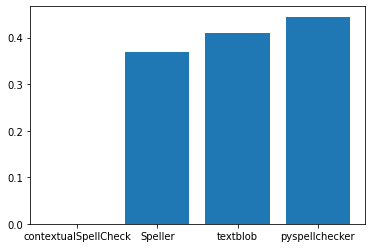

In [25]:
import matplotlib.pyplot as plt
plt.bar(*zip(*accuraicies.items()))
plt.show()

> - The highest Autocorrection on our data is Pyspellchecker
> - The contextualSpellCheck has 0 accuracy, and the make sense as it build for sentances not single words

# Check the model output

In [26]:
df['pyspellcheckerOutput'] = corrected_pyspellchecker

In [27]:
df

,correct,wrong_1,pyspellcheckerOutput
0,perpetrated,perpetrated,perpetrated
1,hazard,hazaard,hazard
2,abandon,abandaondon,abandaondon
3,driven,drirviven,drirviven
4,allow,allllow,allow
...,...,...,...
195,shamed,smahed,smashed
196,singular,singulnagular,singulnagular
197,cabinet,cabinaebinet,cabinaebinet
198,righteous,rightheteous,rightheteous
